In [1]:
"""
All tastes stacked
Different lambdas for each taste but same tau
SINGLE NEURON
"""

'\nAll tastes stacked\nDifferent lambdas for each taste but same tau\nSINGLE NEURON\n'

In [2]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
figsize(11, 9)

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [3]:
data_dir = '/media/bigdata/Abuzar_Data/AM28/AM28_4Tastes_201004_120804/'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dat.default_firing_params

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()
dat.get_stft()
print(np.array(dat.spikes).shape)

All tastes have equal dimensions,concatenating and normalizing


100%|██████████| 2040/2040 [00:02<00:00, 741.75it/s]
2040it [00:00, 4038.35it/s]
2040it [00:00, 6720.34it/s]
2040it [00:00, 8070.98it/s]
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/tables/leaf.py:410: PerformanceWarning: The Leaf ``/stft/stft_array`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/tables/leaf.py:410: PerformanceWarning: The Leaf ``/stft/amplitude_array`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize

(4, 30, 19, 7000)


In [4]:
print(dat.stft_array.shape)

(4, 17, 30, 10, 5000)


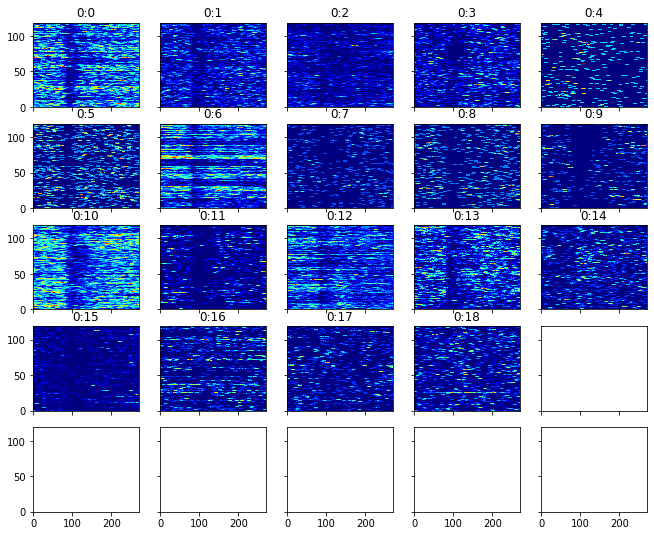

In [5]:
visualize.firing_overview(dat.all_normalized_firing);

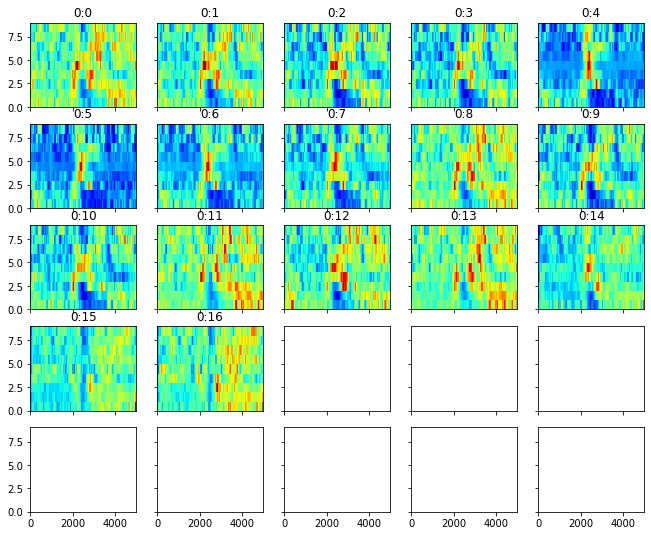

In [6]:
median_amplitude = np.median(dat.amplitude_array,axis=(0,2))
visualize.firing_overview(stats.zscore(median_amplitude,axis=-1));

In [70]:
nrn = np.arange(np.array(dat.spikes).shape[2])
taste_dat = np.array(dat.spikes)[:,:,nrn]
#taste_dat = np.array(dat.spikes)[:,:,nrn]
print(taste_dat.shape)

(4, 30, 19, 7000)


In [71]:
# Convert spikes to counts by binning
time_lims = [1500,4000]
bin_width = 50
t_vec = np.arange(taste_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(taste_dat[...,time_lims[0]:time_lims[1]].reshape(*taste_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

print(this_dat_binned.shape)

(4, 30, 19, 50)


(4, 19, 50)


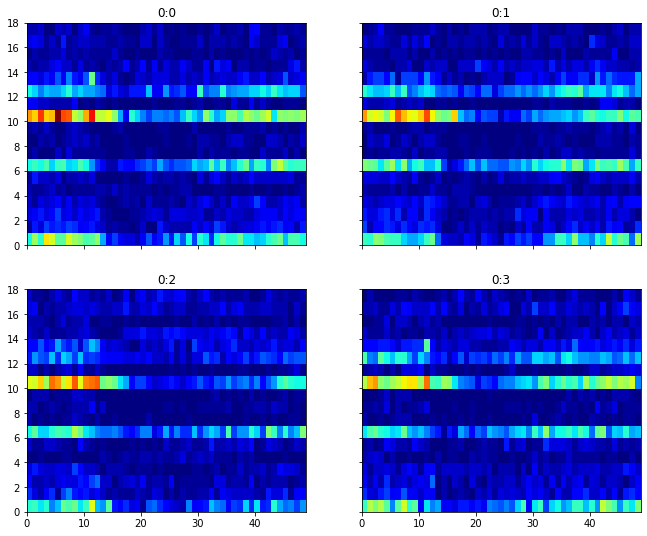

<Figure size 792x648 with 0 Axes>

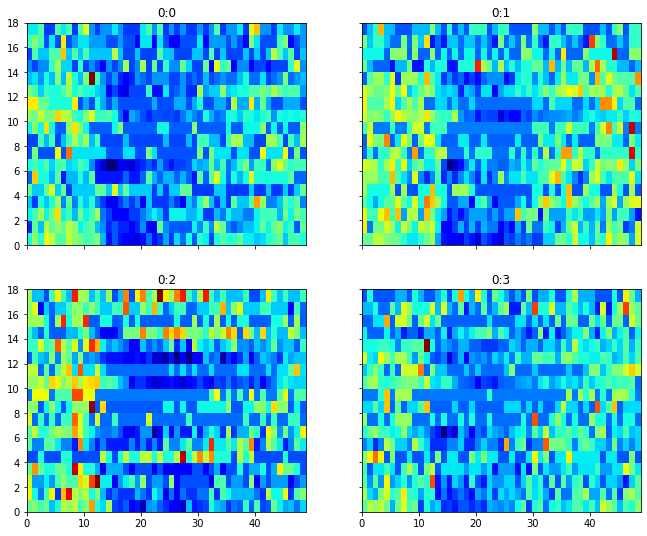

In [72]:
zscore_this_dat = np.array([stats.zscore(np.mean(nrn,axis=0),axis=None) \
                            for nrn in this_dat_binned.swapaxes(0,2)]).swapaxes(0,1)
mean_this_dat = np.mean(this_dat_binned,axis=1)
print(zscore_this_dat.shape)
visualize.firing_overview(mean_this_dat,cmap_lims='shared');
plt.figure();
visualize.firing_overview(zscore_this_dat);

(120, 19, 50)


<Figure size 792x648 with 0 Axes>

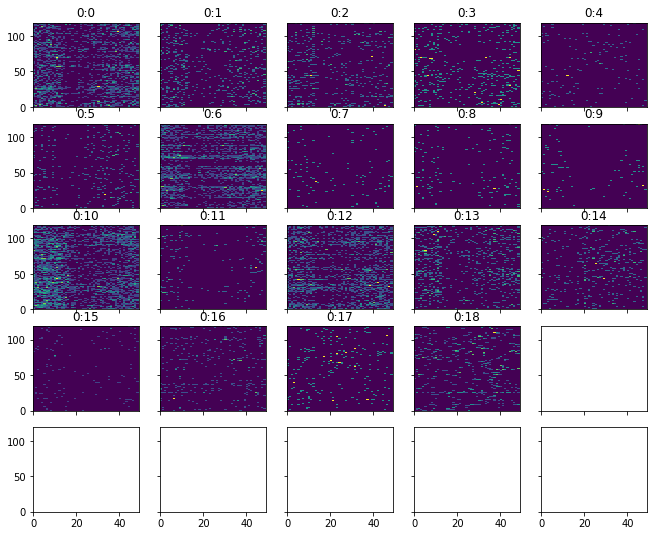

In [73]:
# Pick single trial
trial = np.arange(taste_dat.shape[1])
taste = np.arange(taste_dat.shape[0])

dat_binned_long = np.reshape(this_dat_binned,(-1,*this_dat_binned.shape[-2:]))
print(dat_binned_long.shape)
plt.figure();
visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='viridis');
#dat_binned_long[dat_binned_long>1] = 1
# plt.figure();
# visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='viridis');

In [74]:
states = 4
tastes = this_dat_binned.shape[0]
split_list = np.array_split(this_dat_binned,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
print(split_array.shape)
mean_vals = np.mean(split_array,axis=(2,-1)).swapaxes(0,1)
mean_vals += 0.01 # To avoid zero starting prob
print(mean_vals.shape) # Trials x nrns
# print(mean_vals)
mean_nrn_vals = np.mean(mean_vals,axis=(0,1))
print(mean_nrn_vals.shape) # Trials x nrns

(4, 4, 30, 19, 12)
(4, 4, 19)
(19,)


In [75]:
idx = np.arange(this_dat_binned.shape[-1]) # Index
array_idx = np.broadcast_to(idx, dat_binned_long.shape)
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())
print(array_idx.shape)

0
49
(120, 19, 50)


In [76]:
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)
print(even_switches)
print(even_switches_normal[1:(states)])

[ 0.   12.25 24.5  36.75 49.  ]
[0.25 0.5  0.75]


(19,)
(4, 19)
(4, 4, 19)


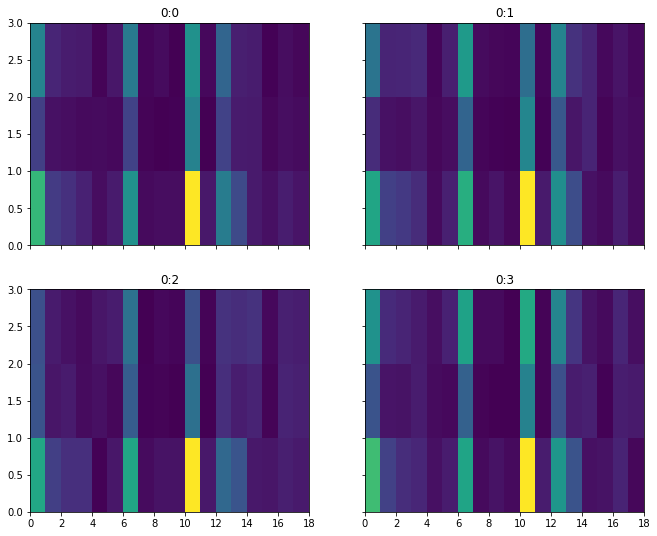

In [77]:
with pm.Model() as model:
    
    
    # SAME LAMBDAS ACROSS ALL TRIALS
    # Finite, but somewhere on the lower end, Beta prior
    # Shared hyperprior for single neuron (across tastes and states)
#     a_lambda = 2
#     b_lambda = 5
    # Priors for each neuron
    lambda_nrn = pm.Exponential('lambda_nrn',1/mean_nrn_vals, shape = (mean_vals.shape[-1]))
#     b_lambda = pm.HalfNormal('b_lambda',3, shape = (mean_vals.shape[-1]))
    
    # Priors for each state, derived from each neuron
    lambda_state = pm.Exponential('lambda_state',lambda_nrn, shape = (mean_vals.shape[1:]))
#     sig_lambda_state = pm.HalfNormal('sig_lambda_state',b_lambda, shape = (mean_vals.shape[1:]))
#     a_lambda_state = pm.HalfNormal('a_lambda_state',a_lambda, shape = (mean_vals.shape[1:]))
#     b_lambda_state = pm.HalfNormal('b_lambda_state',b_lambda, shape = (mean_vals.shape[1:]))
    
    lambda_latent = pm.Exponential('lambda', lambda_state[np.newaxis,:,:], testval = mean_vals, 
                            shape = (mean_vals.shape))

print(lambda_nrn.tag.test_value.shape)
print(lambda_state.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

visualize.firing_overview(lambda_latent.tag.test_value,cmap='viridis');

In [78]:
trial_num = array_idx.shape[0]

with model:
    
    # INDEPENDENT TAU FOR EVERY TRIAL
    a = pm.HalfNormal('a_tau', 3., shape = states - 1)
    b = pm.HalfNormal('b_tau', 3., shape = states - 1)
    
    # Stack produces states x trials --> That gets transposed to trials x states and gets sorted along states (axis=-1)
    # Sort should work the same way as the Ordered transform --> see rv_sort_test.ipynb

    tau_latent = pm.Beta('tau_latent', a, b, 
                           shape = (trial_num, states-1),
                        testval = tt.tile(even_switches_normal[1:(states)],(array_idx.shape[0],1))).sort(axis=-1)
       
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)

print(tau.tag.test_value.shape)
tau_test_value = tau.tag.test_value

(120, 3)


In [79]:
print(array_idx.shape)

(120, 19, 50)


In [80]:
print(tt.tile(array_idx,(3,1,1,1)).swapaxes(0,1).tag.test_value.shape)

(120, 3, 19, 50)


In [81]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    weight_1_stack = tt.nnet.sigmoid(array_idx - tau[:,0][...,np.newaxis,np.newaxis])
    weight_2_stack = tt.nnet.sigmoid(array_idx - tau[:,1][...,np.newaxis,np.newaxis])
    weight_3_stack = tt.nnet.sigmoid(array_idx - tau[:,2][...,np.newaxis,np.newaxis])

#     tau = tau[...,np.newaxis,np.newaxis]
#     weight_stack = tt.nnet.sigmoid(tt.tile(array_idx,(states-1,1,1,1)).swapaxes(0,1) - tau)
    
print(weight_1_stack.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

(120, 19, 50)
(4, 4, 19)


In [82]:
weight_1_test =  weight_1_stack.tag.test_value[0]
lambda_latent_test = lambda_latent.tag.test_value[0]
print(weight_1_test.shape)
print(lambda_latent_test.shape)

(19, 50)
(4, 19)


In [87]:
with model:
    
    taste_label = np.repeat([0,1,2,3],30)
    
#     # 3 states
#     lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
#                 np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
#                 np.multiply(weight_2_stack, lambda_latent[taste_label,2][:,:,np.newaxis])
    
    # 4 states
    lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
                np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
                np.multiply(weight_2_stack * (1 - weight_3_stack), lambda_latent[taste_label][:,2][:,:,np.newaxis]) + \
                np.multiply(weight_3_stack, lambda_latent[taste_label,3][:,:,np.newaxis])

#     lambda_latent_temp = lambda_latent[taste_label,:,:,np.newaxis]
#     print(lambda_latent.tag.test_value.shape)
#     print(lambda_latent_temp.tag.test_value.shape)
    
#     lambda_ = np.multiply(1 - weight_stack[:,0], lambda_latent_temp[:,0]) + \
#                 np.multiply(weight_stack[:,0] * (1 - weight_stack[:,1]), lambda_latent_temp[:,1]) + \
#                 np.multiply(weight_stack[:,1] * (1 - weight_stack[:,2]), lambda_latent_temp[:,2]) + \
#                 np.multiply(weight_stack[:,2], lambda_latent_temp[:,3])

(120, 19, 50)
(120, 19, 50)


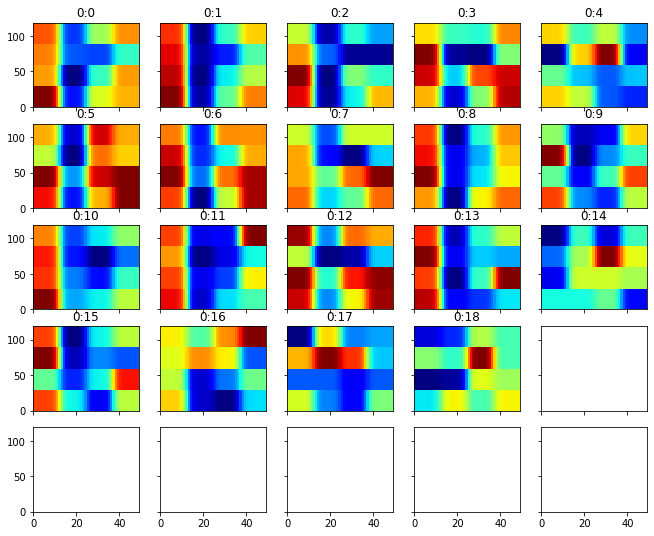

<Figure size 792x648 with 0 Axes>

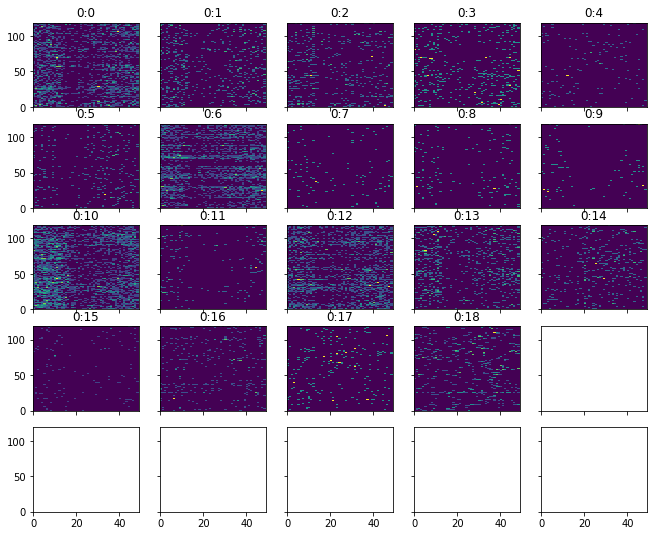

In [88]:
# print(taste_label)
print(weight_1_stack.tag.test_value.shape)
print(lambda_.tag.test_value.shape)
visualize.firing_overview(lambda_.tag.test_value.swapaxes(0,1));
plt.figure()
visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='viridis');

In [89]:
# Using Bernoullo likelihood for count data
with model:
    observation = pm.Poisson("obs", lambda_, observed=dat_binned_long)

ValueError: Variable name obs already exists.

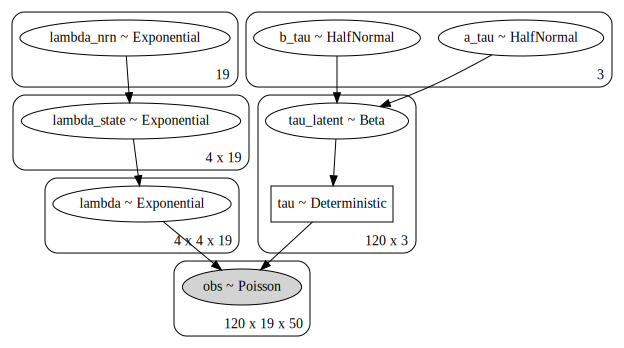

In [90]:
pm.model_to_graphviz(model)

In [91]:
with model:
    #step= pm.Metropolis()
    #step= pm.NUTS()
    #trace = pm.sample(100, tune=10,
    #                  step = step,
    #                  chains = 30, cores = 30)
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=40000, method=inference)
    trace = approx.sample(draws=10000)

  0%|          | 0/40000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 87,691: 100%|██████████| 40000/40000 [10:54<00:00, 61.09it/s]  
Finished [100%]: Average Loss = 87,691


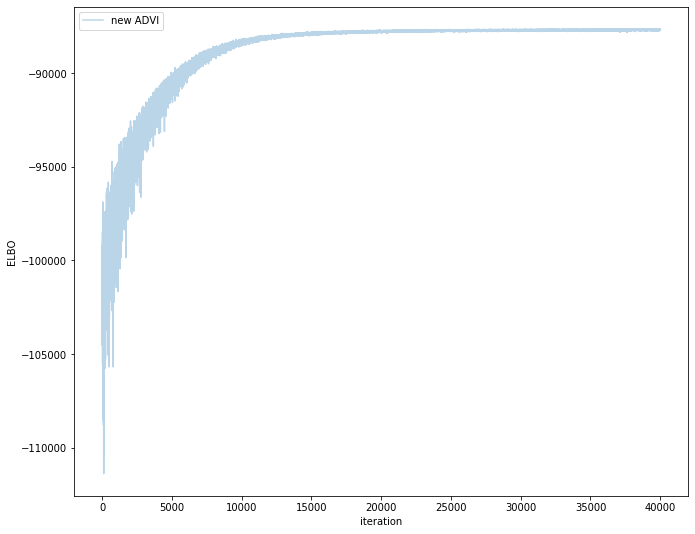

In [92]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
#plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [93]:
print(trace['tau_latent'].shape)

(10000, 120, 3)


In [94]:
# pm.autocorrplot(trace['tau_latent'][:,0,0]);
# pm.autocorrplot(trace['tau_latent'][::20,0,0]);

In [95]:
trace['lambda'].shape

(10000, 4, 4, 19)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

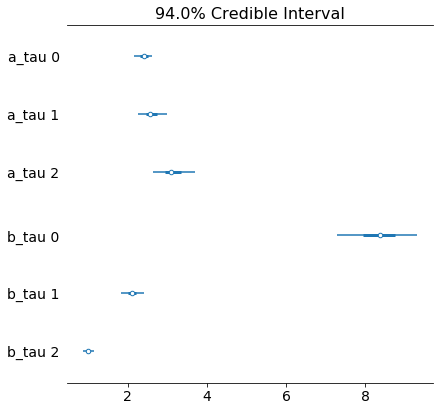

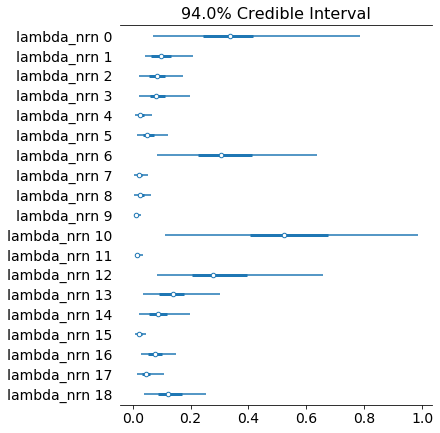

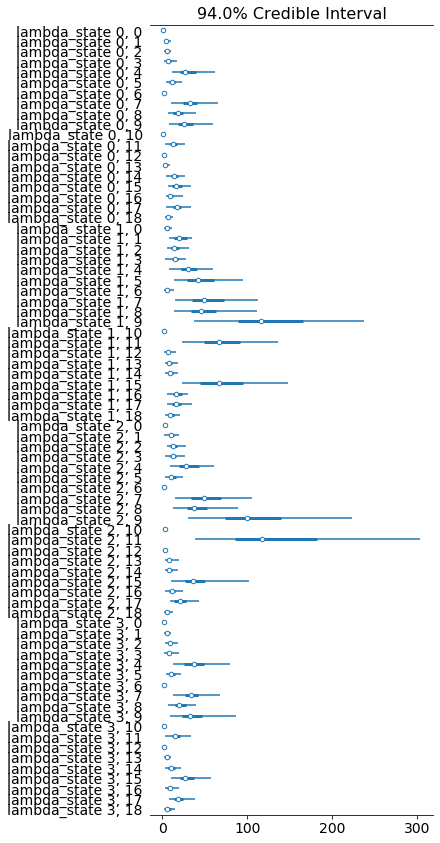

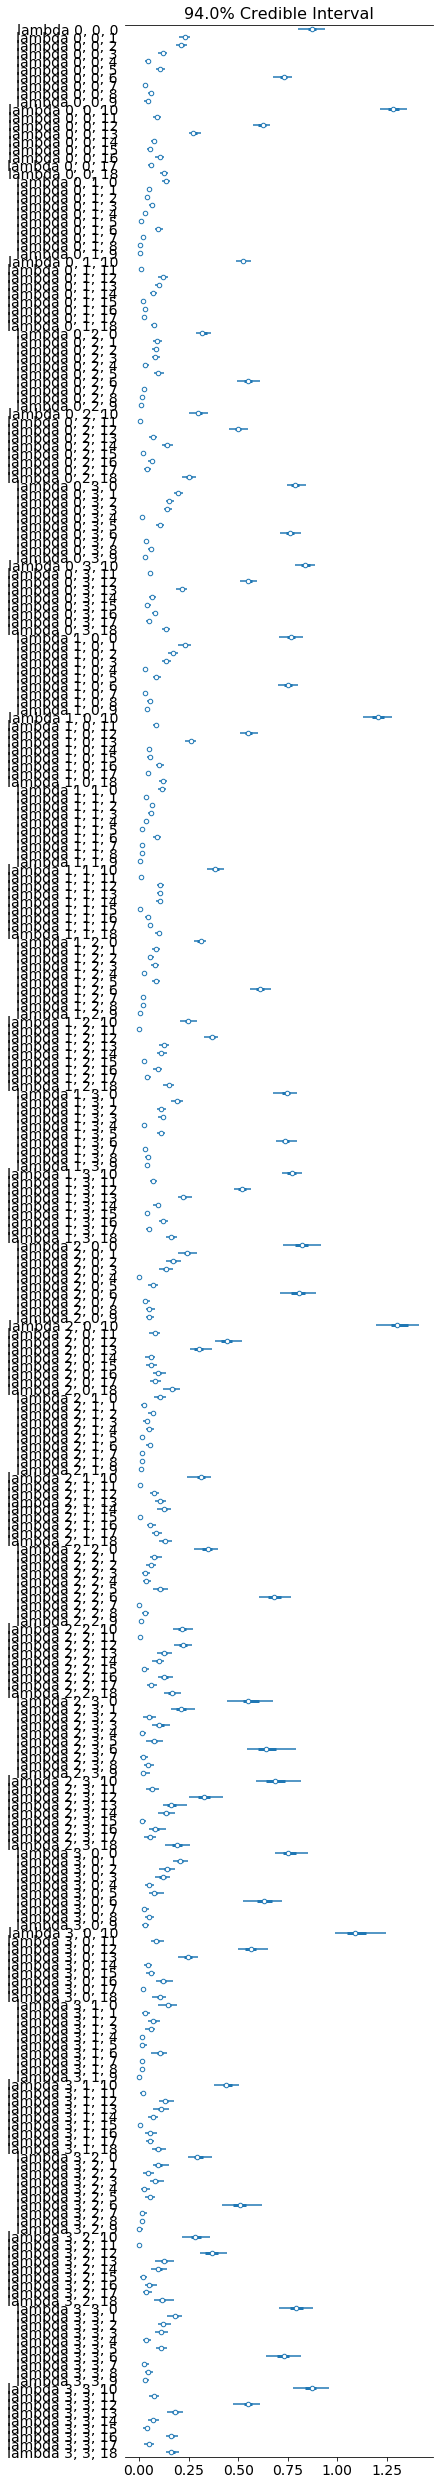

In [96]:
pm.forestplot(trace[::100], var_names = ['a_tau','b_tau']);
pm.forestplot(trace[::100], var_names = ['lambda_nrn']);
# pm.forestplot(trace[::100], var_names = 'tau');
pm.forestplot(trace[::100], var_names = ['lambda_state']);
pm.forestplot(trace[::100], var_names = ['lambda']);

# pm.forestplot(trace, var_names = ['a_tau','b_tau']);
# pm.forestplot(trace, var_names = 'tau');
# pm.forestplot(trace, var_names = ['a_lambda','b_lambda']);
# pm.forestplot(trace, var_names = ['a_lambda_state','b_lambda_state']);
# pm.forestplot(trace, var_names = ['lambda']);

In [97]:
lambda_stack = trace['lambda'].swapaxes(0,1)
tau_samples = trace['tau']
print(tau_samples.shape)
print(lambda_stack.shape)

(10000, 120, 3)
(4, 10000, 4, 19)


In [98]:
mean_tau = np.mean(tau_samples, axis=0)
mean_lambda = np.mean(lambda_stack,axis=1).swapaxes(1,2)
print(mean_tau.shape)
print(mean_lambda.shape)

(120, 3)
(4, 19, 4)


(4, 19, 4)
(4, 19, 4)


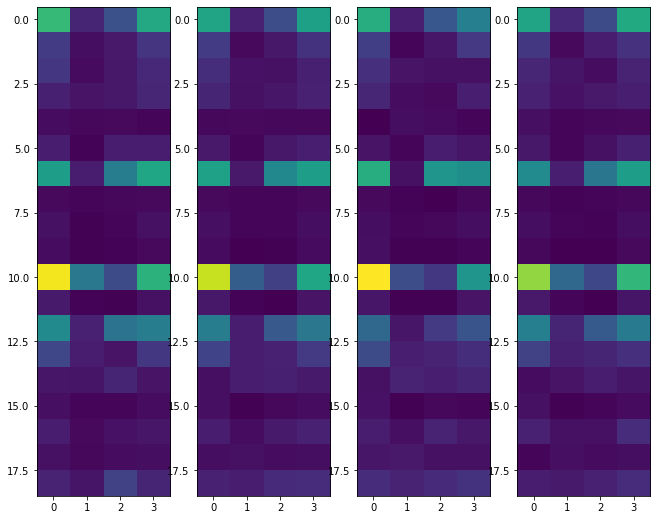

<Figure size 792x648 with 0 Axes>

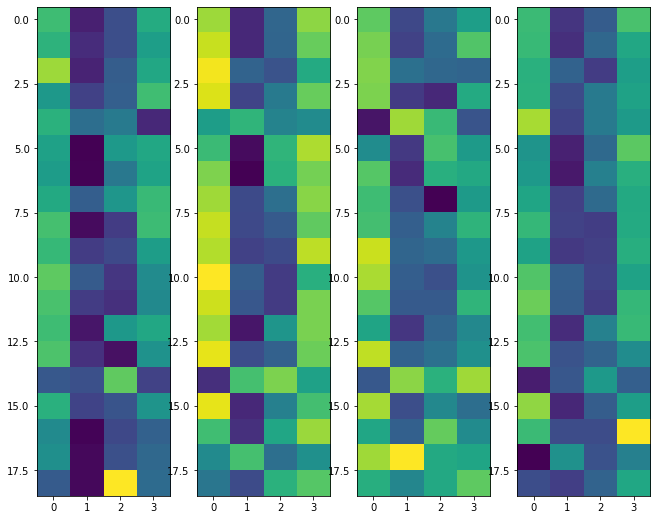

In [99]:
fig,ax = plt.subplots(1,mean_lambda.shape[0]);
for this_ax, this_dat in zip(ax, mean_lambda):
    this_ax.imshow(this_dat, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis',
                                      vmin = 0, vmax = np.max(mean_lambda,axis=None))

plt.figure();
zscore_mean_lambda = np.array([stats.zscore(nrn,axis=None) for nrn in mean_lambda.swapaxes(0,1)]).swapaxes(0,1)
print(mean_lambda.shape)
print(zscore_mean_lambda.shape)
fig,ax = plt.subplots(1,mean_lambda.shape[0]);
for this_ax, this_dat in zip(ax, zscore_mean_lambda):
    this_ax.imshow(this_dat, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis')



(4, 19, 4)


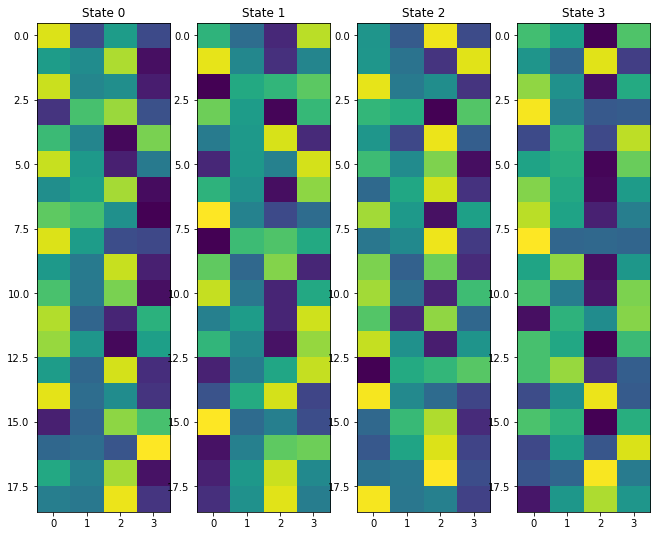

In [100]:
# Chunk subplots by state
swapped_mean_lambda = mean_lambda.swapaxes(0,-1)
print(swapped_mean_lambda.shape)
fig,ax = plt.subplots(1,swapped_mean_lambda.shape[0]);
for num,(this_ax, this_dat) in enumerate(zip(ax, swapped_mean_lambda)):
    this_ax.imshow(stats.zscore(this_dat,axis=-1), interpolation = 'nearest', aspect = 'auto', cmap = 'viridis')
    this_ax.set_title('State {}'.format(num))

In [101]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)
ppc['obs'].shape

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
  0%|          | 0/2000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 2000/2000 [00:39<00:00, 50.91it/s]


(2000, 120, 19, 50)

In [102]:
mean_ppc = np.mean(ppc['obs'],axis=0)
std_ppc = np.std(ppc['obs'],axis=0)
print(mean_ppc.shape)

(120, 19, 50)


In [103]:
mean_mean_tau = np.mean(tau_samples,axis=(0,1))
mean_mean_ppc = np.mean(mean_ppc,axis=1)
zscore_mean_mean_ppc = np.array([stats.zscore(nrn,axis=None) for nrn in mean_mean_ppc.swapaxes(0,1)]).swapaxes(0,1)
print(mean_mean_tau.shape)
print(mean_mean_ppc.shape)
print(zscore_mean_mean_ppc.shape)

(3,)
(120, 50)
(120, 50)


(1200000, 3)


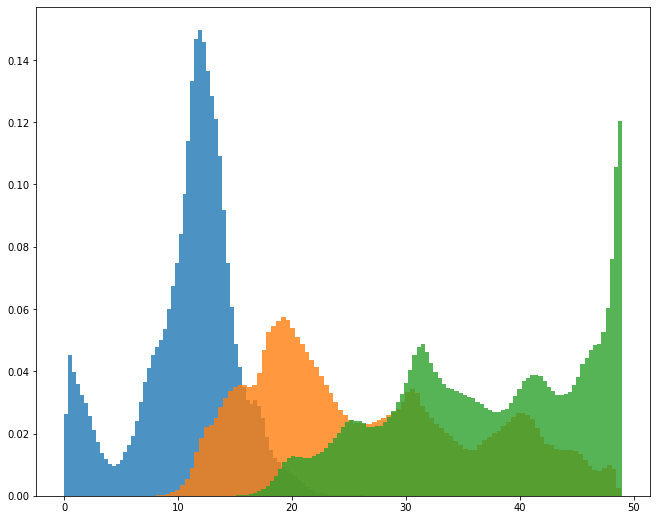

In [104]:
long_tau_samples = tau_samples.reshape((-1, tau_samples.shape[-1]))
print(long_tau_samples.shape)
for switch in range(long_tau_samples.shape[-1]):
     plt.hist(long_tau_samples[...,switch],bins = 100, density = True,alpha = 0.8)
    
# for this_ax in ax[-1,:]:
#     this_ax.set_xticks(np.arange(0,len(binned_t_vec),tick_interval));
#     this_ax.set_xticklabels(binned_t_vec[::tick_interval],rotation='vertical');

In [105]:
zscore_mean_ppc = stats.zscore(mean_ppc, axis=(0,1))
print(zscore_mean_ppc.shape)

(120, 19, 50)


In [106]:
plot_spikes = dat_binned_long>0

In [107]:
# channel = 12
# stft_cut = stats.zscore(dat.amplitude_array,axis=-1)
# stft_cut = stft_cut[:,12,...,time_lims[0]:time_lims[1]]
# stft_cut = np.reshape(stft_cut,(-1,*stft_cut.shape[2:]))
# print(stft_cut.shape)
# stft_ticks = dat.time_vec[time_lims[0]:time_lims[1]]*1000
# stft_tick_inds = np.arange(0,len(stft_ticks),250)
# visualize.imshow(np.median(stft_cut,axis=0))

# mean_tau_stft = (mean_tau/np.max(mean_tau,axis=None))*stft_cut.shape[-1]
# print(mean_tau_stft[0])
# print(dat.freq_vec)
# print(mean_tau_stft.shape)
# print(stft_ticks.shape)

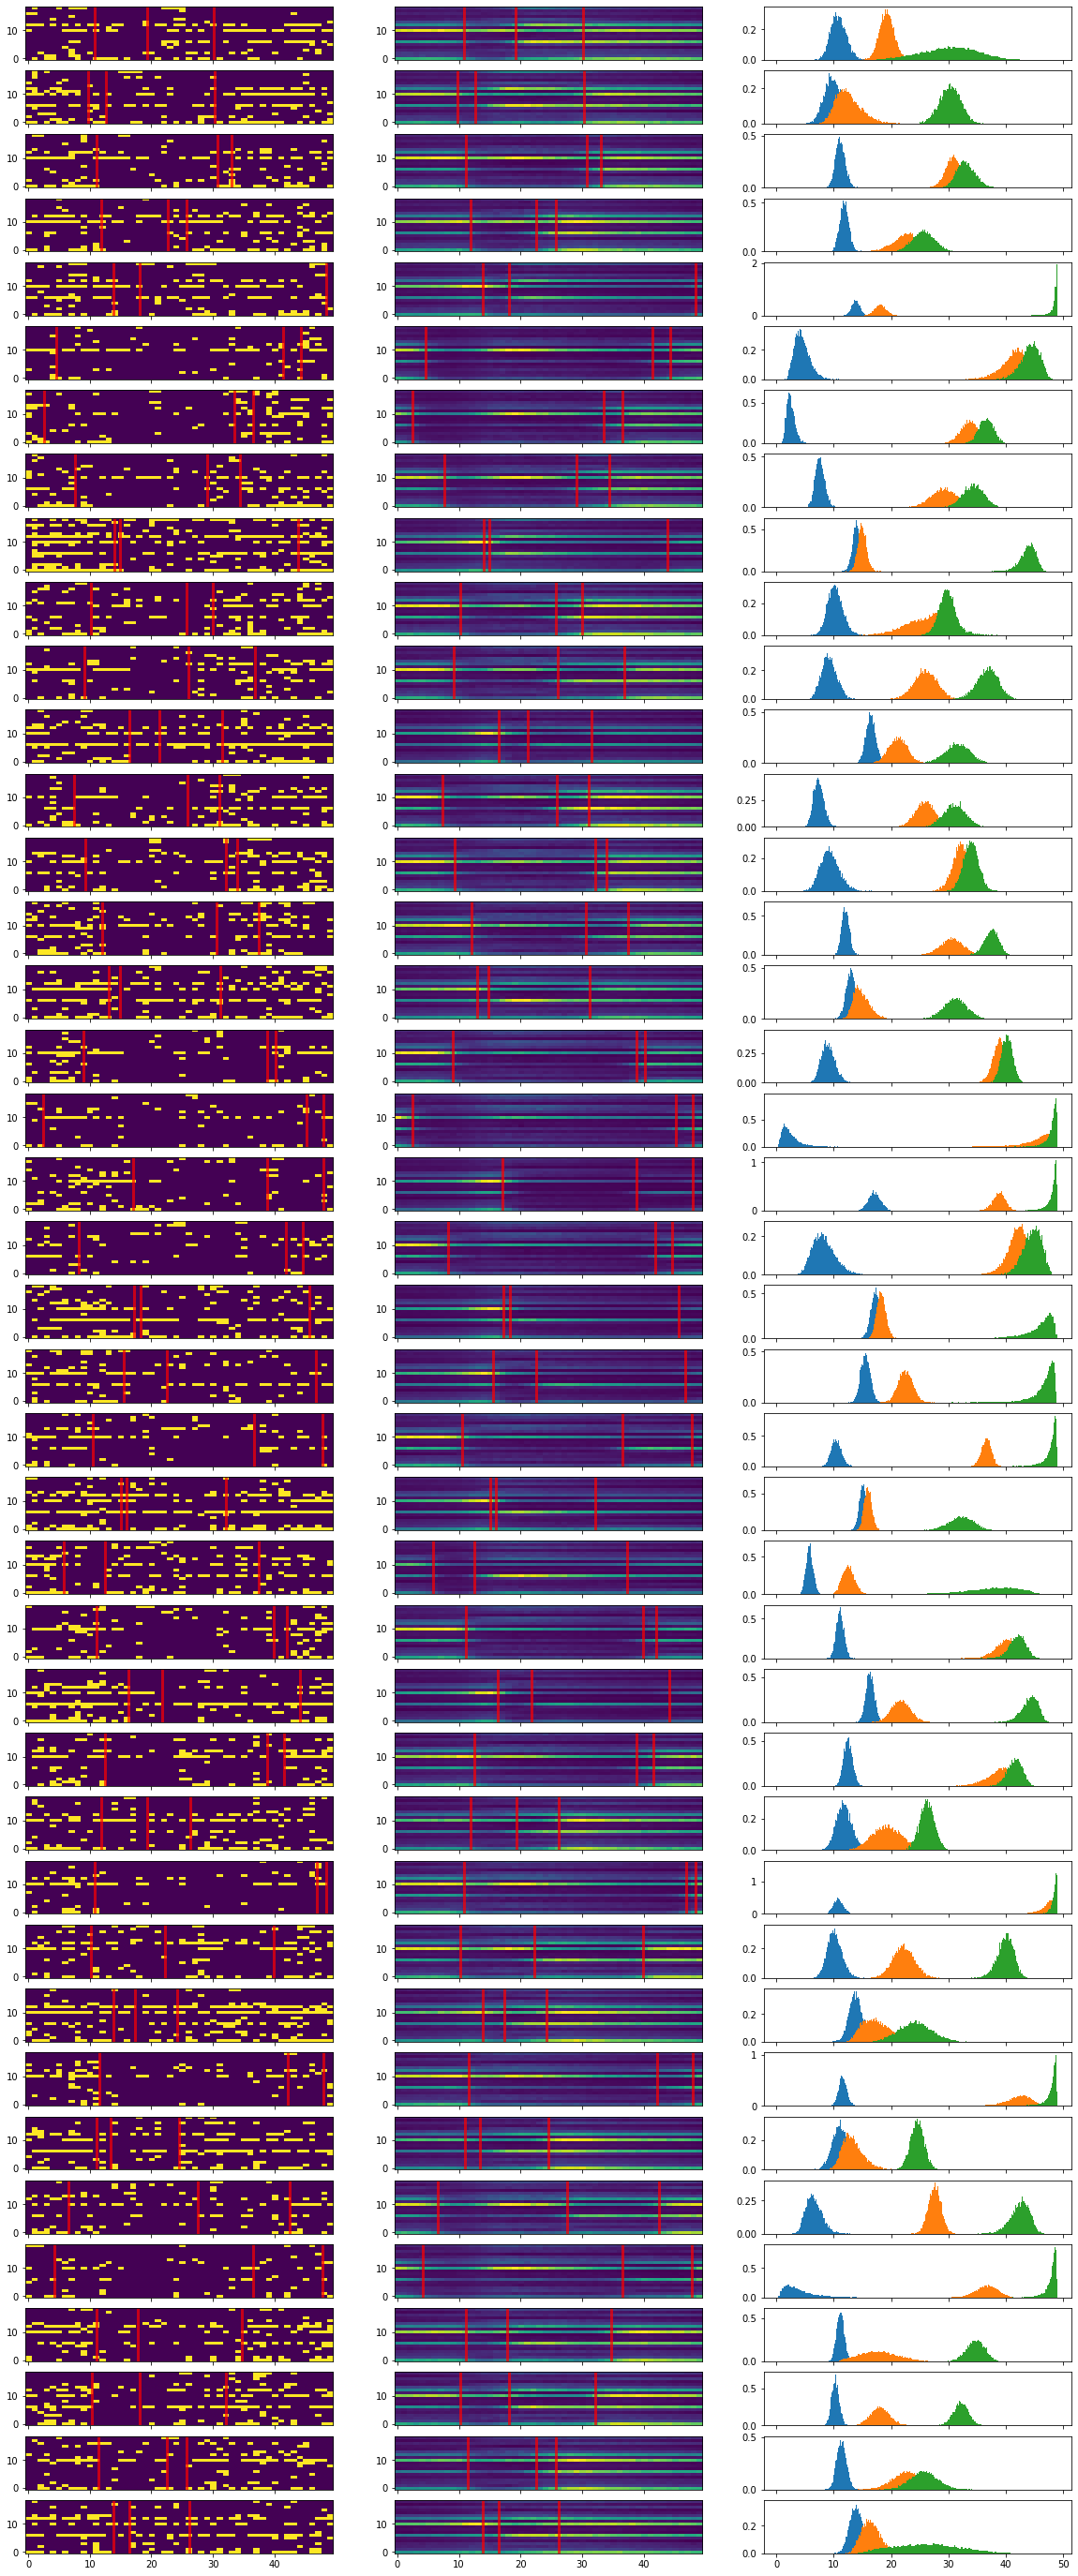

In [108]:
# Overlay raster with CDF of switchpoints
trial_count = 40
tick_interval = 5
trial_inds = np.sort(np.random.choice(np.arange(mean_ppc.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count,3,sharex='col', figsize = (20,50))
for num,trial in enumerate(trial_inds):
    ax[num,0].imshow(plot_spikes[trial],aspect='auto',origin='lower')
    #ax[num,1].imshow(stft_cut[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,1].imshow(zscore_mean_ppc[trial], aspect='auto',origin='lower')
    ax[num,0].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    #ax[num,1].vlines(mean_tau_stft[trial],-0.5,stft_cut.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    ax[num,1].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    
    #ax[num,1].set_xticks(stft_tick_inds)
    #ax[num,1].set_xticklabels(stft_ticks[stft_tick_inds],rotation='vertical')

    for state in range(tau_samples.shape[-1]):
        ax[num,2].hist(tau_samples[:,trial,state], bins = 100, density = True)

# for col in [0,2,3]:
#     plt.sca(ax[-1,col])
#     plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
#     plt.xlim(0,len(binned_t_vec))


In [55]:
# See whether you can extract differences in valve opening times from transition points
taste_tau = []
for taste in sorted(set(taste_label)):
    taste_tau.append(mean_tau[taste_label==taste])
taste_tau = np.array(taste_tau)
print(taste_tau.shape)
taste_mean_tau = np.mean(taste_tau,axis=1)
taste_mean_time = taste_mean_tau[:,0]*bin_width
print(taste_mean_time - np.min(taste_mean_time))

(2, 60, 3)
[ 0.        27.3732009]


In [56]:
# For visualization
# Take firing around each transition and stack it together to make a PSTH (not mean firing)
# Before and after alignment
window_radius_time = 300 # ms
window_radius_bins = window_radius_time//bin_width
print(window_radius_bins)

# Convert tau to interegers
int_mean_tau = np.vectorize(np.int)(mean_tau)

print(dat_binned_long.shape)
print(int_mean_tau.shape)

6
(120, 19, 50)
(120, 3)


In [57]:
# Take entire radius if available or whatever there is otherwise
# Iterate over changepoints and trials
# trials x neuron x switches x window_diameter
aligned_spikes = np.ones((*dat_binned_long.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(aligned_spikes.shape)

(120, 19, 3, 12)


In [58]:
# Spikes aligned to trial-specific transitions
for trial in range(dat_binned_long.shape[0]):
    for switch in range(mean_tau.shape[-1]):
        
        # Check whether we can pick out a window
        lower_bound = (int_mean_tau[trial,switch] - window_radius_bins)
        fin_lower_bound = lower_bound * (lower_bound > 0)
        upper_bound = (int_mean_tau[trial,switch] + window_radius_bins)
        fin_upper_bound = upper_bound * (upper_bound < dat_binned_long.shape[-1]) + \
                                            dat_binned_long.shape[-1] * (upper_bound > dat_binned_long.shape[-1])

        # Done this way so all windows can be accomodated whether they are of the expected size or not
        lower_window = dat_binned_long[trial,:,fin_lower_bound:int_mean_tau[trial,switch]]
        upper_window = dat_binned_long[trial,:,int_mean_tau[trial,switch]:fin_upper_bound]
        #If window is smaller than the expected size, put it in centered on transition
        aligned_spikes[trial,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
        aligned_spikes[trial,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window

In [59]:
# Spikes aligned to average transitions
unaligned_spikes = np.ones((*dat_binned_long.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(unaligned_spikes.shape)
int_unaligned_tau = np.vectorize(np.int)(np.mean(mean_tau,axis=0))
# Spikes aligned to trial-specific transitions
for switch in range(int_unaligned_tau.shape[-1]):

    # Check whether we can pick out a window
    lower_bound = (int_unaligned_tau[switch] - window_radius_bins)
    fin_lower_bound = lower_bound * (lower_bound > 0)
    upper_bound = (int_unaligned_tau[switch] + window_radius_bins)
    fin_upper_bound = upper_bound * (upper_bound < dat_binned_long.shape[-1]) + \
                                        dat_binned_long.shape[-1] * (upper_bound > dat_binned_long.shape[-1])

    # Done this way so all windows can be accomodated whether they are of the expected size or not
    lower_window = dat_binned_long[:,:,fin_lower_bound:int_unaligned_tau[switch]]
    upper_window = dat_binned_long[:,:,int_unaligned_tau[switch]:fin_upper_bound]
    #If window is smaller than the expected size, put it in centered on transition
    unaligned_spikes[:,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
    unaligned_spikes[:,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window

(120, 19, 3, 12)


In [60]:
# break down aligned_spikes by taste
aligned_list = []
for taste in sorted(set(taste_label)):
    aligned_list.append(aligned_spikes[taste_label==taste])
taste_aligned_spikes = np.array(aligned_list)
print(taste_aligned_spikes.shape)

(2, 60, 19, 3, 12)


(19, 3, 120, 12)


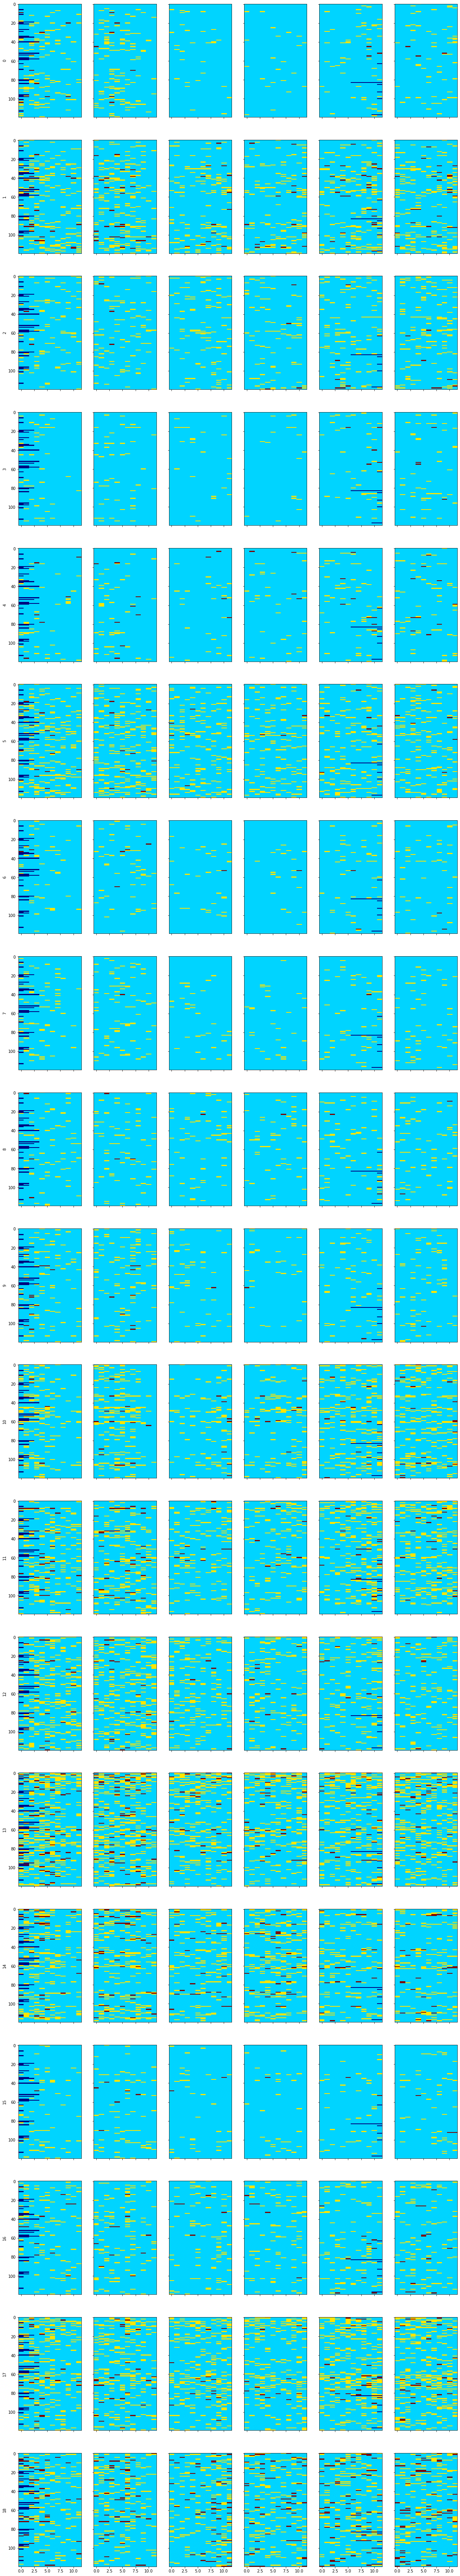

In [61]:
plot_dat_aligned = np.moveaxis(aligned_spikes,0,2)
plot_dat_unaligned = np.moveaxis(unaligned_spikes,0,2)
print(plot_dat_aligned.shape)

fig, ax = plt.subplots(plot_dat_aligned.shape[0],plot_dat_aligned.shape[1]*2,
                      sharex=True, sharey=True, figsize=(20,120))
iters = np.ndindex(plot_dat_aligned.shape[:2])
for this_iter in iters:
    #spikes = np.where(plot_dat[this_iter])
    #this_ax.scatter(spikes[1],spikes[0],s=2,alpha=0.7,marker = "|")
    ax[this_iter[0],2*this_iter[1]].imshow(plot_dat_aligned[this_iter[0],this_iter[1]],aspect='auto',cmap='jet',vmin=-1,vmax=2)
    ax[this_iter[0],(2*this_iter[1])+1].imshow(plot_dat_unaligned[this_iter[0],this_iter[1]],aspect='auto',cmap='jet',vmin=-1,vmax=2)
    
for num,this_ax in enumerate(ax[:,0].flatten()):
    this_ax.set_ylabel(num)

(19, 3, 2, 12)


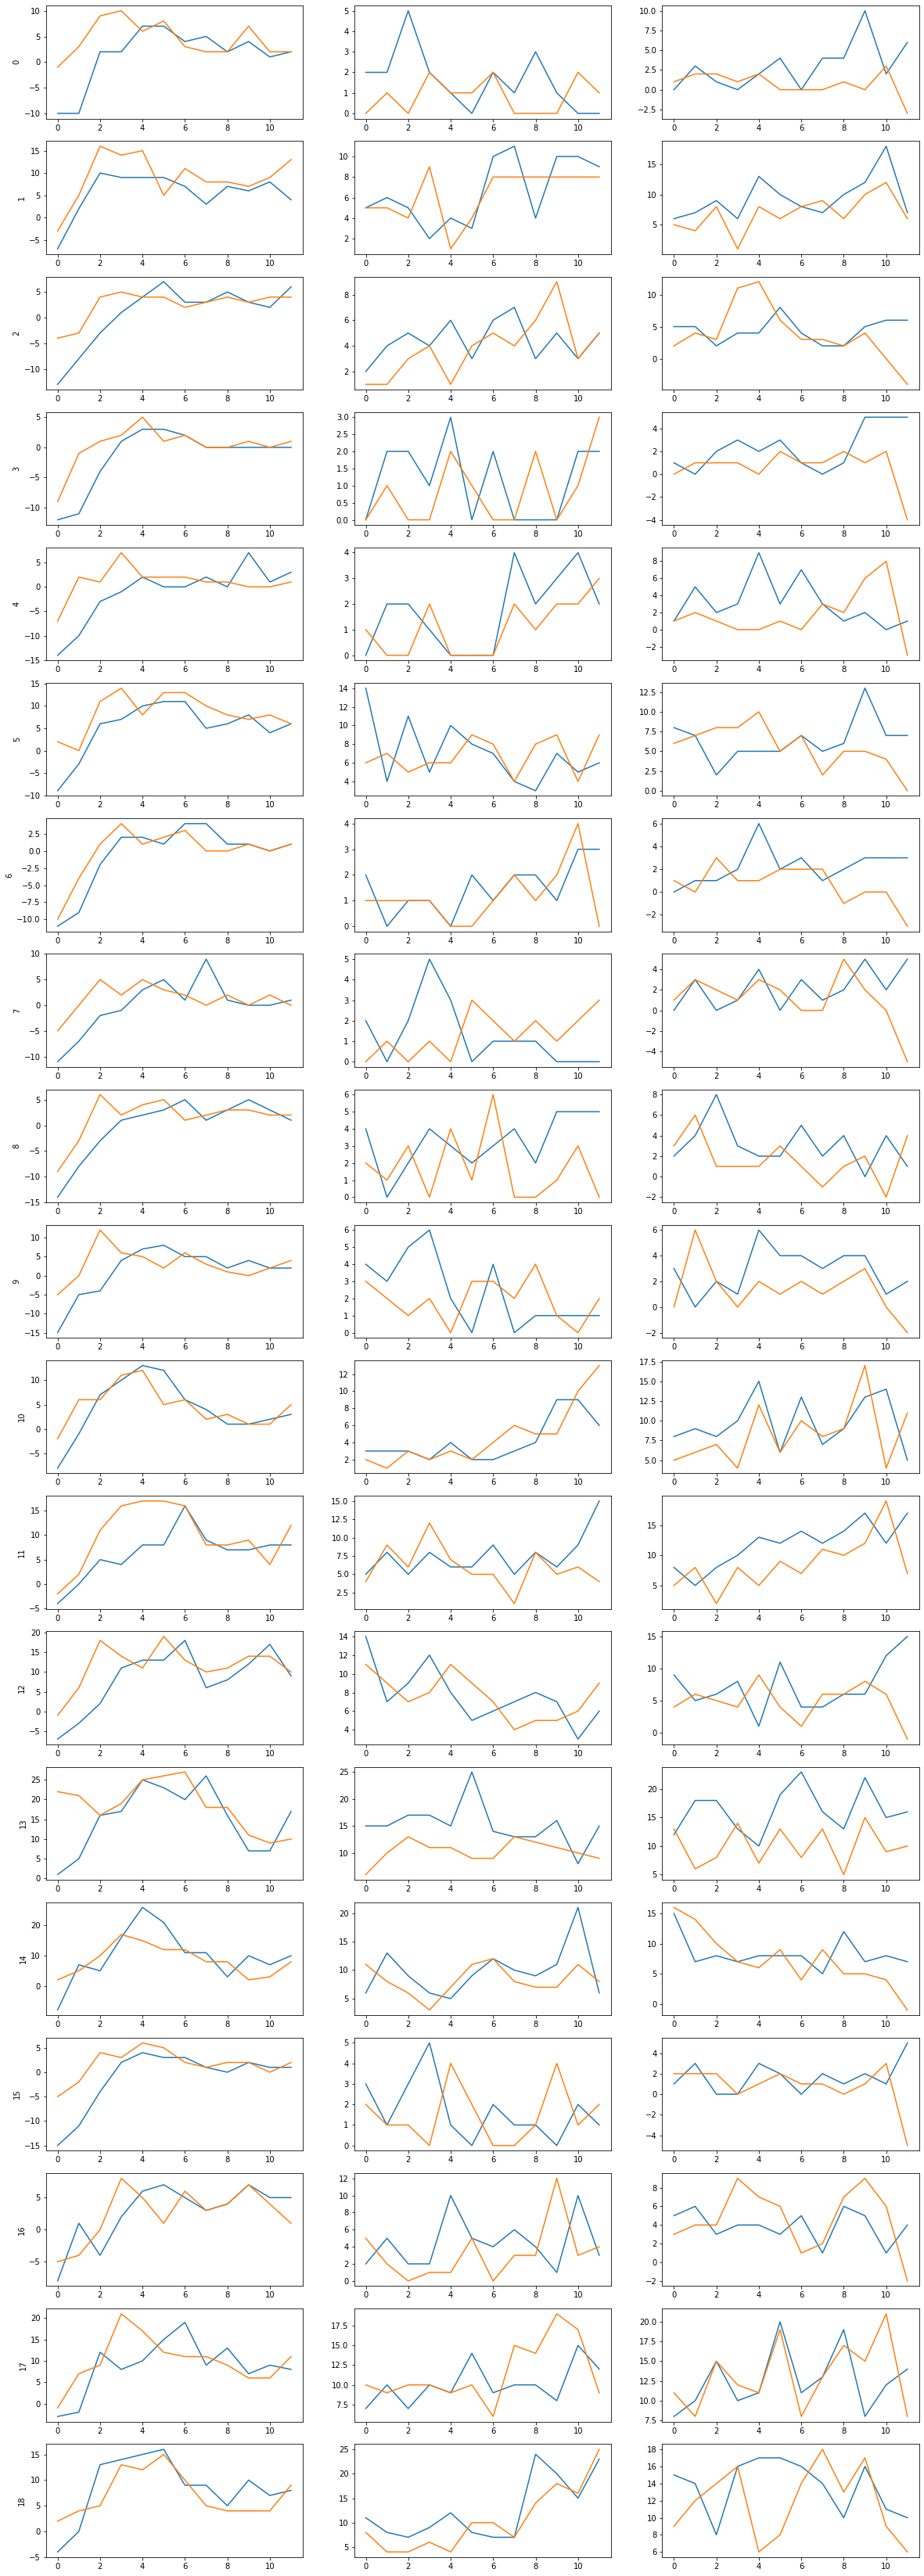

In [62]:
sum_aligned_taste_spikes = np.moveaxis(np.sum(taste_aligned_spikes,axis=1),0,2)
print(sum_aligned_taste_spikes.shape)
fig, ax = plt.subplots(sum_aligned_taste_spikes.shape[0],sum_aligned_taste_spikes.shape[1],
                      figsize = (20,60))
iters = np.ndindex(ax.shape)
for this_iter,this_ax in zip(iters,ax.flatten()):
    this_ax.plot(sum_aligned_taste_spikes[this_iter].T)
for num,this_ax in enumerate(ax[:,0].flatten()):
    this_ax.set_ylabel(num)

(19, 3, 12)
(19, 3, 12)


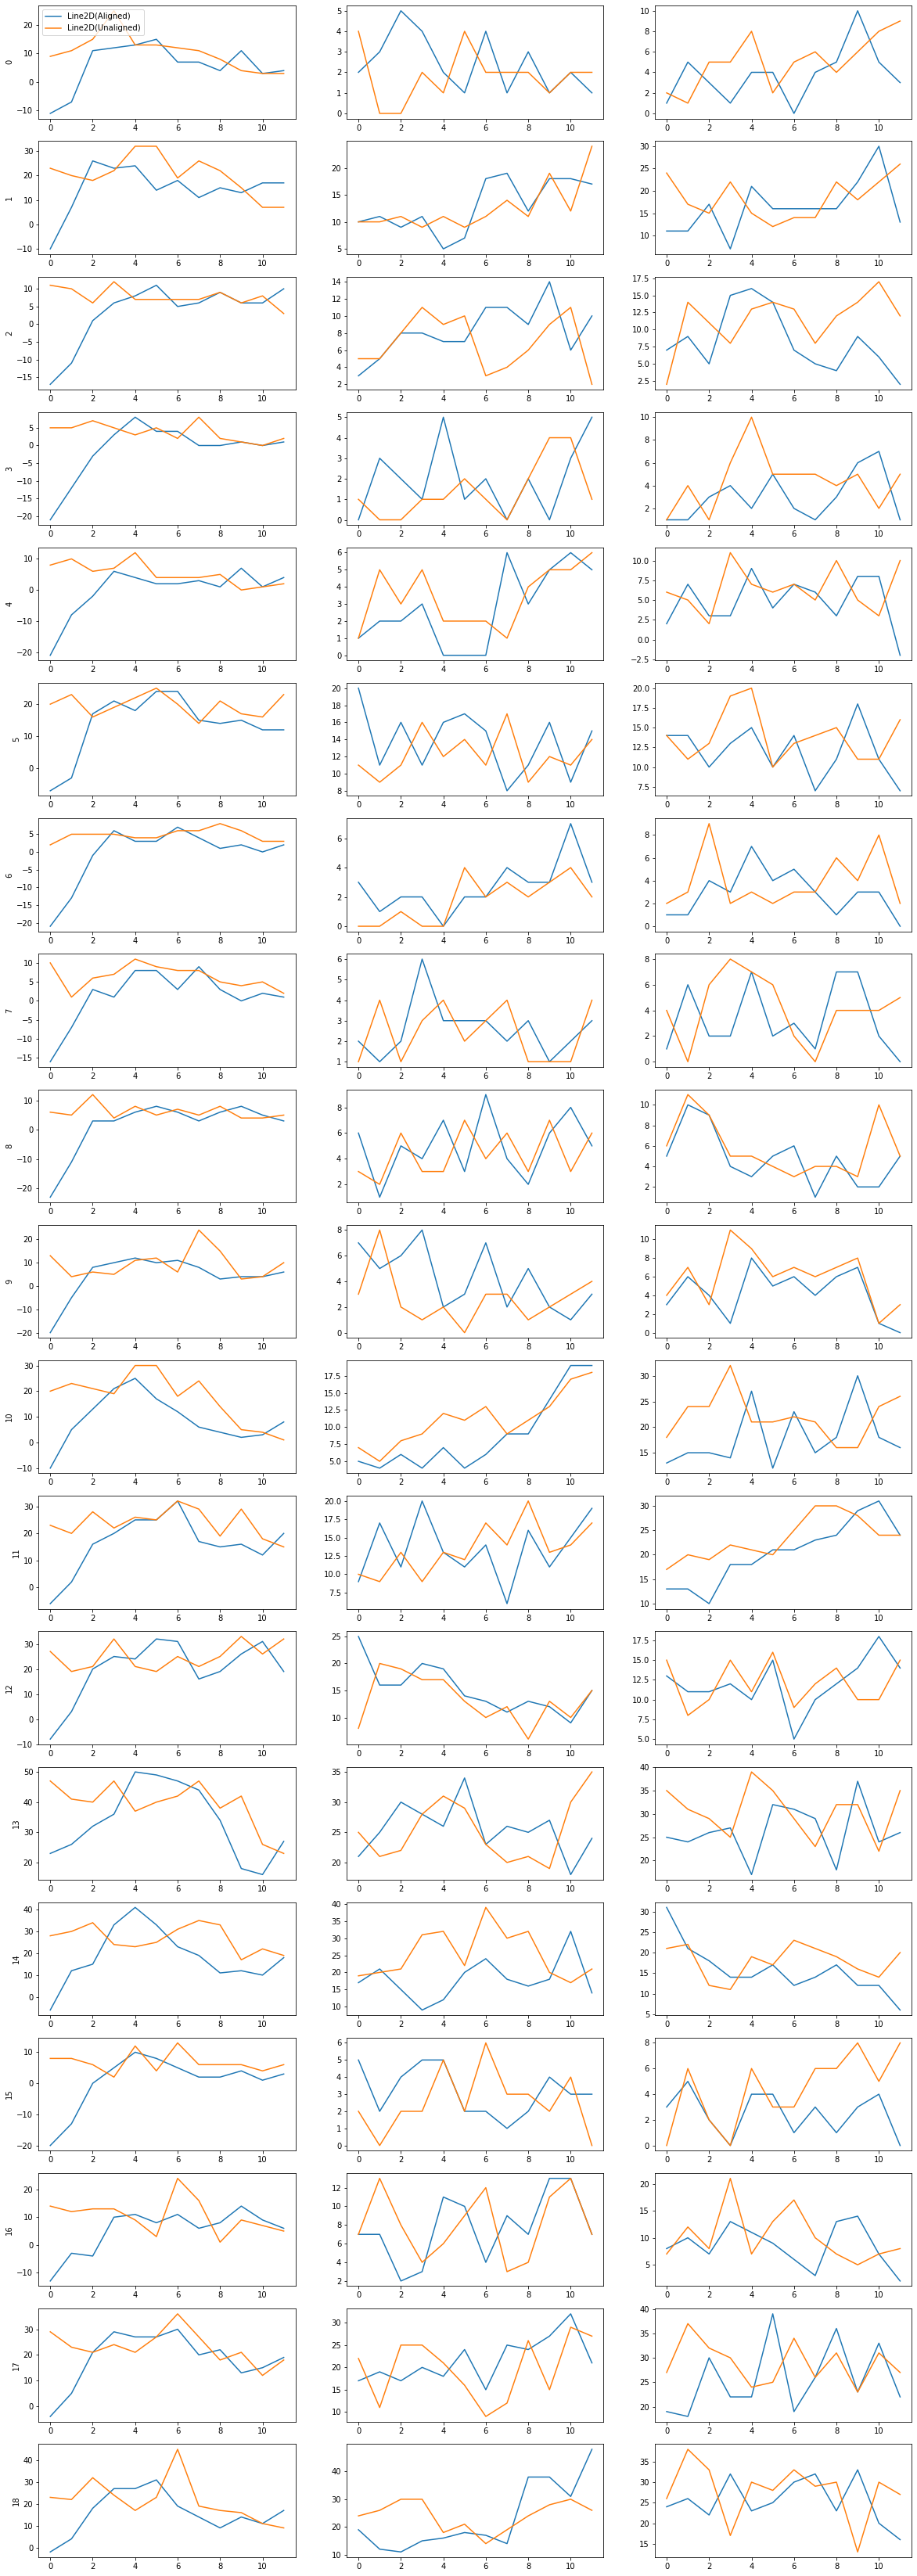

In [63]:
## Compare mean aligned psth (across all tastes) to mean psth at mean changepoint time
sum_aligned_spikes = np.sum(plot_dat_aligned,axis=2)
sum_unaligned_spikes = np.sum(plot_dat_unaligned,axis=2)
print(sum_aligned_spikes.shape)
print(sum_unaligned_spikes.shape)
fig, ax = plt.subplots(sum_aligned_spikes.shape[0],sum_aligned_spikes.shape[1],
                      figsize = (20,60))
iters = np.ndindex(ax.shape)
for this_iter,this_ax in zip(iters,ax.flatten()):
    this_ax.plot(sum_aligned_spikes[this_iter])
    this_ax.plot(sum_unaligned_spikes[this_iter])
for num,this_ax in enumerate(ax[:,0].flatten()):
    this_ax.set_ylabel(num)
plt.sca(ax[0,0])
plt.legend([Line2D([0],[0],label = 'Aligned',color='blue'), 
            Line2D([0],[0],label = 'Unaligned', color = 'orange')],
          loc = 'upper left');